In [1]:
# To ginore the Warnings
import warnings
warnings.filterwarnings(action='ignore',category=UserWarning)
warnings.filterwarnings(action="ignore",category=RuntimeWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)

#To Data Manipulation and perform Matrix operations 
import numpy as np
import pandas as pd

#Plotting Libarries 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

#To check missing Values
import missingno as msn

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this

from fuzzywuzzy import fuzz
import tqdm

# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# Using TSNE for Dimentionality reduction for 18 Features(Generated after cleaning the data) to 3 dimention
from sklearn.manifold import TSNE


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss,confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from collections import Counter, defaultdict
from scipy.sparse import coo_matrix, hstack

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import xgboost as xgb
from xgboost import XGBClassifier


###  Data Extraction and Sampling

In [2]:
#Read the Dataset
complete_df=pd.read_csv('train.csv')

In [3]:
print("Before Sampling the data set shape:",complete_df.shape)

Before Sampling the data set shape: (404290, 6)


In [4]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
quora_df=complete_df.sample(frac=0.3,random_state=1).reset_index(drop=True)

In [5]:
print("After Sampling the data set shape:",quora_df.shape)

After Sampling the data set shape: (121287, 6)


In [6]:
print('Number of Observations in the dataset :',quora_df.shape[0])
print('Number of Features in the dataset :',quora_df.shape[1])
print("List of Features in the dataset:",quora_df.columns.values.tolist(),end='')

Number of Observations in the dataset : 121287
Number of Features in the dataset : 6
List of Features in the dataset: ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']

In [7]:
quora_df.drop(columns=['id'],axis=1,inplace=True)
quora_df.head()

,qid1,qid2,question1,question2,is_duplicate
0,33086,348102,How can I stop playing video games?,Should I stop playing video games with my child?,0
1,73272,8624,Who is better Donald Trump or Hillary Clinton?,Why is Hillary Clinton a better choice than Do...,1
2,359482,359483,What do you think is the chance that sometime ...,Do you think there will be another world war/n...,1
3,1357,47020,Why are so many questions posted to Quora that...,Why do people write questions on Quora that co...,1
4,334315,334316,Can there even be a movie ever rated 10/10 on ...,What are your 10/10 movies?,0


In [8]:
quora_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121287 entries, 0 to 121286
Data columns (total 5 columns):
qid1            121287 non-null int64
qid2            121287 non-null int64
question1       121286 non-null object
question2       121285 non-null object
is_duplicate    121287 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.6+ MB


### Check Class Balance

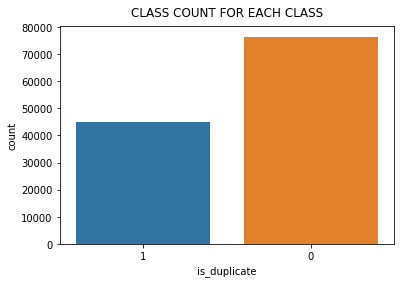

In [9]:
sns.countplot(x='is_duplicate',data=quora_df,order=[1,0])
plt.title("Class Count for each class".upper(),pad=10)
plt.show()

In [10]:
print(str(np.round(quora_df.is_duplicate.value_counts()/quora_df.shape[0]*100,2)))

0    62.97
1    37.03
Name: is_duplicate, dtype: float64


######  Observation: Majority Class is  Class 0 (Questions which are not similar)with 63.06% and Minority Class is  Class 1(Questions which are similar) with 36.94%

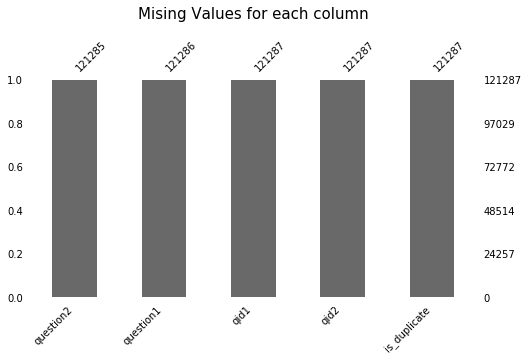

In [11]:
msn.bar(quora_df,sort='ascending',fontsize=10,figsize=(8,4))
plt.title("Mising Values for each column",fontsize=15,pad=20)
plt.show()

###### Observation: Question2 , Question1  have 1 missing values in each column

In [12]:
#Fill the Null Values
quora_df.fillna(value='',inplace=True)

In [13]:
quora_df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## Exploratory Data Analysis

Total number of  Unique Questions are: 197145

Number of unique questions that appear more than one time: 24804 (12.58%)

Max number of times a single question is repeated: 48



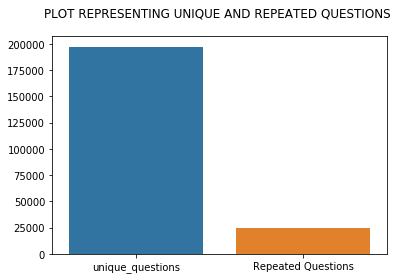

In [14]:
qids = pd.Series(quora_df.qid1.tolist()+quora_df.qid2.tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,np.round(qs_morethan_onetime/unique_qs*100,2)))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts().values)))


x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]
plt.figure(figsize=(6, 4))
plt.title ("Plot representing unique and repeated questions ".upper(),pad=20)
sns.barplot(x,y)
plt.show()

## Check for Redundent Data

In [15]:
print ("Number of duplicate Entries :-",np.sum(quora_df.duplicated()))

Number of duplicate Entries :- 0


Maximum number of times a single question is repeated: 48



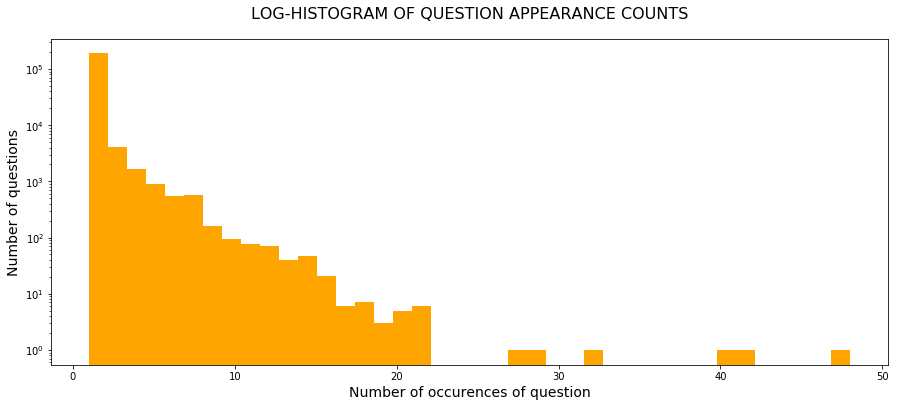

In [16]:
plt.figure(figsize=(15, 6))
plt.hist(qids.value_counts(), bins=40,color='Orange')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts'.upper(),pad=20,fontsize=16)
plt.xlabel('Number of occurences of question',fontsize=14)
plt.ylabel('Number of questions',fontsize=14)
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

######  Observation: only 4 Questions appear more than 25 times , and 10^5 questions appear only very very few time like once or twice

In [17]:
def basic_feature_generation(df):
    
    common_df=pd.DataFrame()
    
    common_df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    common_df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')

    common_df['q1len']=df.question1.str.len()
    common_df['q2len']=df.question2.str.len()

    common_df['q1_n_words']=df.question1.apply(lambda que:len(que.split(" ")))
    common_df['q2_n_words']=df.question2.apply(lambda que:len(que.split(" ")))

    def normalized_word_common(row):
        w1=set(row['question1'].lower().strip().split(" ")) 
        w2=set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(w1 & w2)

    common_df['word_Common']=df.apply(normalized_word_common,axis=1)

    def normalized_word_total(row):
        w1=set(row['question1'].lower().strip().split(" ")) 
        w2=set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(w1) + len(w2))
    common_df['word_Total']=df.apply(normalized_word_total,axis=1)

    def normalized_word_share(row):
        w1=set(row['question1'].lower().strip().split(" ")) 
        w2=set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    common_df['word_Share']=df.apply(normalized_word_share,axis=1)

    common_df['freq_q1+q2'] = common_df['freq_qid1']+common_df['freq_qid2']
    common_df['freq_q1-q2'] = abs(common_df['freq_qid1']-common_df['freq_qid2'])
    

    common_df.head()
    
    return common_df


In [18]:
basic_fet=pd.concat([quora_df,basic_feature_generation(quora_df)],axis=1)

In [19]:
print ("Minimum length of the questions in question1 : " , min(basic_fet['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(basic_fet['q2_n_words']))
print('-'*52)
print ("Average length of the questions in question1 : " , np.round(np.mean(basic_fet['q1_n_words'])))
print ("Average length of the questions in question2 : " , np.round(np.mean(basic_fet['q2_n_words'])))
print('-'*52)
print ("Maximum length of the questions in question1 : " , max(basic_fet['q1_n_words']))
print ("Maximum length of the questions in question2 : " , max(basic_fet['q2_n_words']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
----------------------------------------------------
Average length of the questions in question1 :  11.0
Average length of the questions in question2 :  11.0
----------------------------------------------------
Maximum length of the questions in question1 :  73
Maximum length of the questions in question2 :  237


In [20]:
print ("Number of Questions with minimum length [question1] :", basic_fet[basic_fet['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", basic_fet[basic_fet['q2_n_words']== 1].shape[0])
print('-'*58)
print ("Number of Questions with Average length [question1] :", basic_fet[basic_fet['q1_n_words']== 11].shape[0])
print ("Number of Questions with Average length [question2] :", basic_fet[basic_fet['q2_n_words']== 11].shape[0])
print('-'*58)
print ("Number of Questions with maximum length [question1] :", basic_fet[basic_fet['q1_n_words']== 73].shape[0])
print ("Number of Questions with maximum length [question2] :", basic_fet[basic_fet['q2_n_words']== 237].shape[0])

Number of Questions with minimum length [question1] : 24
Number of Questions with minimum length [question2] : 6
----------------------------------------------------------
Number of Questions with Average length [question1] : 9036
Number of Questions with Average length [question2] : 8377
----------------------------------------------------------
Number of Questions with maximum length [question1] : 1
Number of Questions with maximum length [question2] : 3


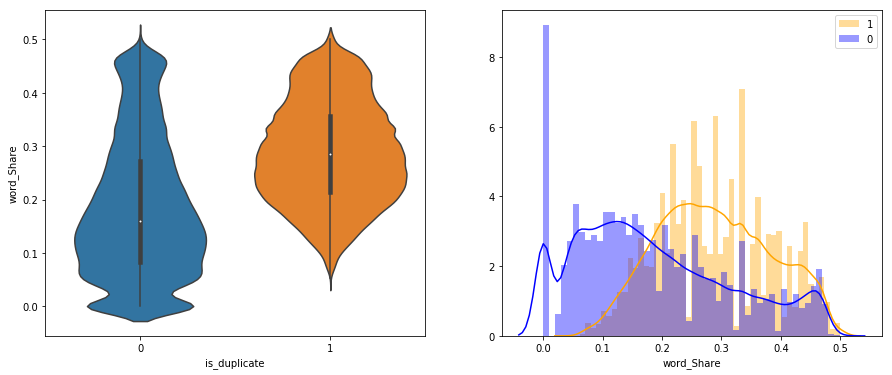

In [21]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)

sns.violinplot(x = 'is_duplicate', y = 'word_Share', data = basic_fet)
plt.subplot(1,2,2)

sns.distplot(basic_fet[basic_fet['is_duplicate'] == 1.0]['word_Share'] , label = "1",color='Orange')
sns.distplot(basic_fet[basic_fet['is_duplicate'] == 0.0]['word_Share'] , label = "0",color='B')
plt.legend()
plt.show()

######  Observation: 
##### --> min as 10% and Max as 50%  words shareed by for similar questions
##### --> most  of the non similar questions dont have word_share .Peak values at 0 to 0.2
##### --> Even some questions have more than  40% of word_share  they are classified as non Similar questions

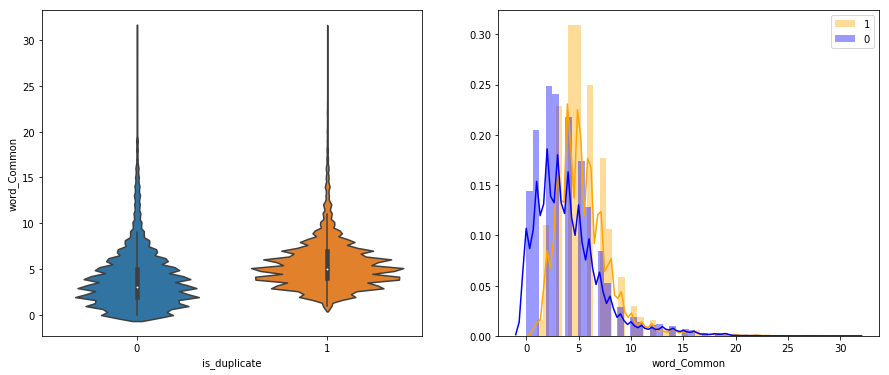

In [22]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = basic_fet)

plt.subplot(1,2,2)
sns.distplot(basic_fet[basic_fet['is_duplicate'] == 1.0]['word_Common'] , label = "1", color = 'Orange')
sns.distplot(basic_fet[basic_fet['is_duplicate'] == 0.0]['word_Common'] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

######  Observation :  Most of the Common words are over lapping for class_0 and Class_1 .It is clearly appearing 

## Text Processing

In [23]:
# To get the results in 4 decemal points
safe_div = 0.0001 
stop_words = stopwords.words("english")


def preprocess(sent):

    sent=str(sent).lower()
    sent=sent.replace(",000,000", "m").replace(",000","k")
    sent=sent.replace("′", "'").replace("’", "'")
    
    sent = re.sub(r"won't", "will not", sent)
    sent = re.sub(r"can\'t", "can not", sent)
    sent = re.sub(r"cannot", "can not", sent)

    # general
    sent = re.sub(r"n\'t", " not", sent)
    sent = re.sub(r"\'re", " are", sent)
    sent = re.sub(r"\'s", " is", sent)
    sent = re.sub(r"\'d", " would", sent)
    sent = re.sub(r"\'ll", " will", sent)
    sent = re.sub(r"\'t", " not", sent)
    sent = re.sub(r"\'ve", " have", sent)
    sent = re.sub(r"\'m", " am", sent)
    sent = re.sub("what's", "what is",sent)
    sent = re.sub("'ve", "have",sent)
    sent = re.sub("'s", "own",sent)

    sent=sent.replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ")
    sent = re.sub(r"([0-9]+)000000", r"\1m", sent)
    sent = re.sub(r"([0-9]+)000", r"\1k", sent)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(sent) == type(''):
        sent = re.sub(pattern, ' ', sent)
    
    
    if type(sent) == type(''):
        sent = porter.stem(sent)
        pure_text = BeautifulSoup(sent)
        sent= pure_text.get_text()

    
    return sent
    

In [24]:
def get_token_features(q1,q2):
    
    token_words=np.zeros(13)
    
    q1_tokens=q1.split()
    q2_tokens=q2.split()
    
    if(len(q1_tokens)==0 or len(q2_tokens)==0):
        return token_words
    
    q1_words=[word for word in q1_tokens if word not in stop_words]
    q2_words=[word for word in q2_tokens if word not in stop_words]
    
    q1_stop_words=[word for word in q1_tokens if word in stop_words]
    q2_stop_words=[word for word in q2_tokens if word in stop_words]
    
    common_word_count=len(set(q1_words) & set(q2_words))
    common_stop_count=len(set(q1_stop_words) & set(q2_stop_words))
    common_token_count=len(set(q1_tokens) & set(q2_tokens))
    
    token_words[0]=common_word_count/(min(len(q1_words),len(q2_words))+safe_div)
    token_words[1]=common_word_count/(max(len(q1_words),len(q2_words))+safe_div)
    token_words[2]=common_word_count/((len(q1_words)+len(q2_words))/2+safe_div)
    
    token_words[3]=common_stop_count/(min(len(q1_stop_words),len(q1_stop_words))+safe_div)
    token_words[4]=common_stop_count/(max(len(q1_stop_words),len(q2_stop_words))+safe_div)
    token_words[5]=common_stop_count/(((len(q1_stop_words)+len(q2_stop_words))/2)+safe_div)
    
    token_words[6]=common_token_count/(min(len(q1_tokens),len(q1_tokens))+safe_div)
    token_words[7]=common_token_count/(max(len(q1_tokens),len(q2_tokens))+safe_div)
    token_words[8]=common_token_count/(((len(q1_tokens)+len(q2_tokens))/2)+safe_div)
    
    # First word of both question is same or not
    token_words[9] = int(q1_tokens[0] == q2_tokens[0])
    
    # Last word of both question is same or not
    token_words[10] = int(q1_tokens[-1] == q2_tokens[-1])
    
    token_words[11] = abs(len(q1_tokens) - len(q2_tokens))
    
     #Average Token Length of both Questions
    token_words[12] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_words

In [25]:
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [26]:
def extract_features(df):
    
    print('Preprocessing...')
    adv_df=pd.DataFrame()
    # preprocessing each question
    adv_df["question1"] = df["question1"].fillna("").apply(preprocess)
    adv_df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    print("Tokenization....")
    token_features = adv_df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    

    adv_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    adv_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    adv_df["cwc_mean"]      = list(map(lambda x: x[2], token_features))
    
    adv_df["csc_min"]       = list(map(lambda x: x[3], token_features))
    adv_df["csc_max"]       = list(map(lambda x: x[4], token_features))
    adv_df["csc_mean"]      = list(map(lambda x: x[5], token_features))
    
    adv_df["ctc_min"]       = list(map(lambda x: x[6], token_features))
    adv_df["ctc_max"]       = list(map(lambda x: x[7], token_features))
    adv_df["ctc_mean"]      = list(map(lambda x: x[8], token_features))
    
    adv_df["first_word_eq"] = list(map(lambda x: x[9], token_features))
    adv_df["last_word_eq"]  = list(map(lambda x: x[10], token_features))
    adv_df["abs_len_diff"]  = list(map(lambda x: x[11], token_features))
    adv_df["mean_len"]      = list(map(lambda x: x[12], token_features))
    
    
    print("fuzzy features....")
    adv_df["token_set_ratio"]       = adv_df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    adv_df["token_sort_ratio"]      = adv_df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    adv_df["fuzz_ratio"]            = adv_df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    adv_df["fuzz_partial_ratio"]    = adv_df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    adv_df["longest_substr_ratio"]  = adv_df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    adv_df.drop(columns=['question1','question2'],inplace=True,axis=1)
    return adv_df

In [27]:
# Add some words which are necessary and remove which are not required

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
titles=['Non simialr','similar']

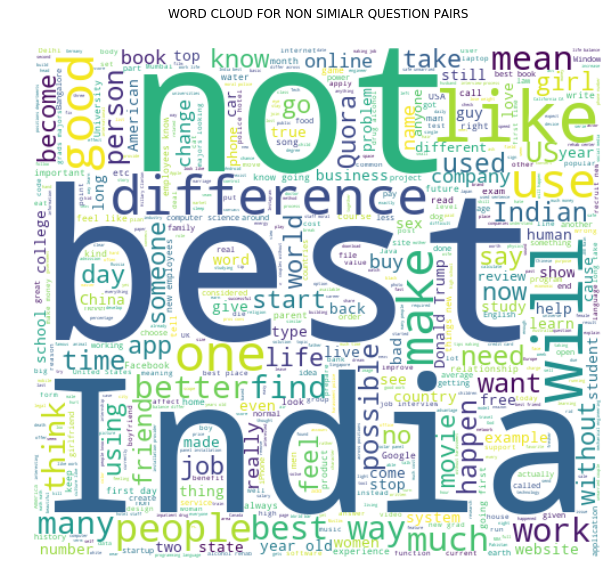

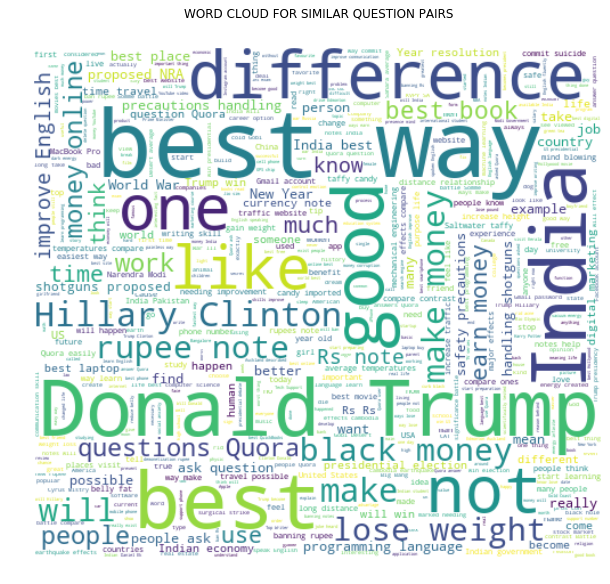

In [28]:
for i in tqdm.tqdm_notebook(range(2)):
    df_sample=quora_df[quora_df['is_duplicate']==i]
    merge_ques=np.dstack([df_sample.question1,df_sample.question2]).flatten()
    
    display_string=""
    for word in tqdm.tqdm_notebook(merge_ques):
        display_string=display_string+word+' '
        
    wc = WordCloud(width = 500, height = 450,background_color="white", max_words=len(merge_ques), 
               stopwords=stopwords).generate(display_string)
    plt.figure(figsize=(15,8),constrained_layout=True)
    plt.title("Word Cloud for {} Question pairs".format(titles[i]).upper(),pad=30)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
plt.show()

######  Observations:
######  --> India, Best, Will,Like not,Difference etc appeared most of the times in non similar questions
######  --> Best, Donald Trump,Best Way,Difference ,Hillary Clinton etc most of the times in non similar questions
######  --> Common words from Similar and NonSimilar questions:India,Best,Difference etc

In [29]:
advance_fet=pd.concat([basic_fet,extract_features(quora_df)],axis=1)

Preprocessing...
Tokenization....
fuzzy features....


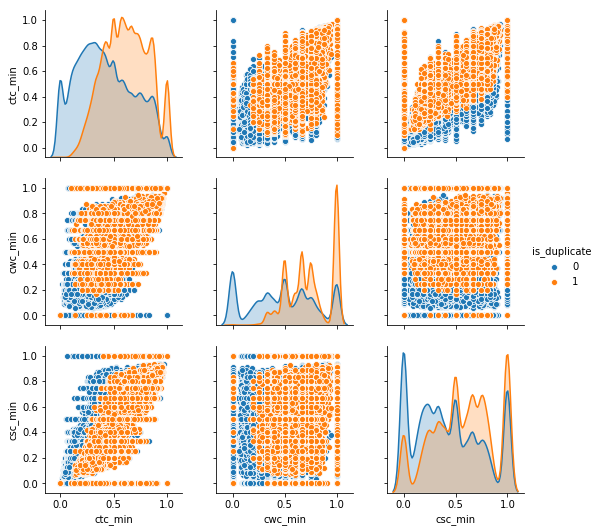

In [30]:
sns.pairplot(advance_fet[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']], 
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min'])
plt.show()

######  Observation: Most of the common,stopwords are overlapping from similar to non simialr questions with minimum Length as criteria 

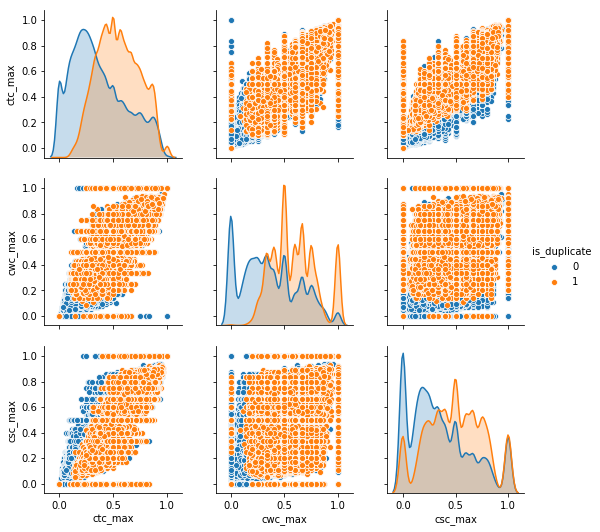

In [31]:
sns.pairplot(advance_fet[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']], 
             hue='is_duplicate', vars=['ctc_max', 'cwc_max', 'csc_max'])
plt.show()

###### Observation: Most of the common,stopwords are overlapping from similar to non simialr questions with Maximum length as criteria 

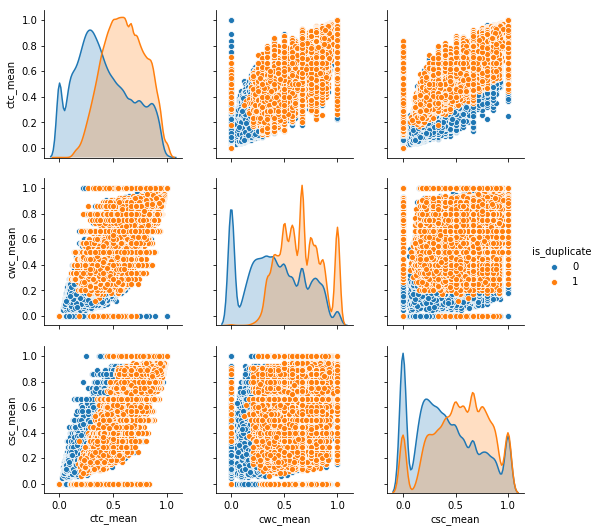

In [32]:
sns.pairplot(advance_fet[['ctc_mean', 'cwc_mean', 'csc_mean', 'is_duplicate']], 
             hue='is_duplicate', vars=['ctc_mean', 'cwc_mean', 'csc_mean'])
plt.show()

###### Observation: Most of the common,stopwords are overlapping from similar to non simialr questions with Mean  as criteria 

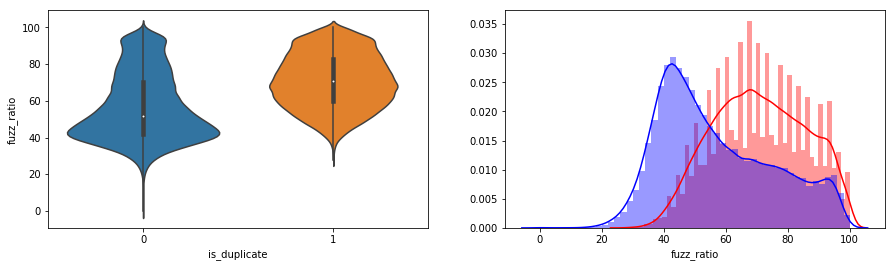

In [33]:
plt.figure(figsize=(15, 4))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data =advance_fet)

plt.subplot(1,2,2)
sns.distplot(advance_fet[advance_fet['is_duplicate'] == 1.0]['fuzz_ratio'] , label = "1", color = 'red')
sns.distplot(advance_fet[advance_fet['is_duplicate'] == 0.0]['fuzz_ratio'] , label = "0" , color = 'blue' )
plt.show()

######  Observation: 
##### -> most of the non similar questions have a fuzz_ration below 50  
##### -> most of the  similar questions have a fuzz_ration above  40  

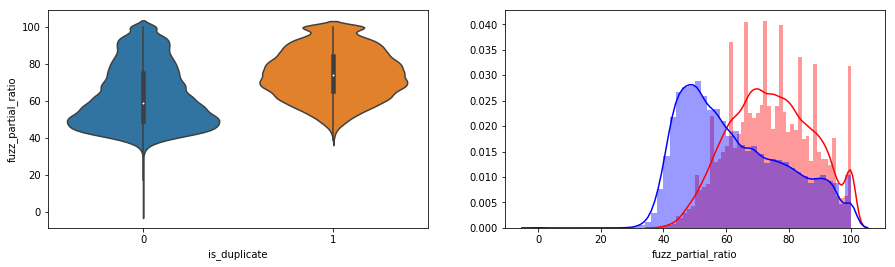

In [34]:
plt.figure(figsize=(15, 4))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data =advance_fet)

plt.subplot(1,2,2)
sns.distplot(advance_fet[advance_fet['is_duplicate'] == 1.0]['fuzz_partial_ratio'] , label = "1", color = 'red')
sns.distplot(advance_fet[advance_fet['is_duplicate'] == 0.0]['fuzz_partial_ratio'] , label = "0" , color = 'blue' )
plt.show()

#####  Observation: 
##### -> most of the non similar questions have a fuzz_partial_ratio between 38 and 50
##### -> most of the  similar questions have a fuzz_ration above  40
##### -> most of the  similar and non similar questions  share the same fuzz_partial_ration


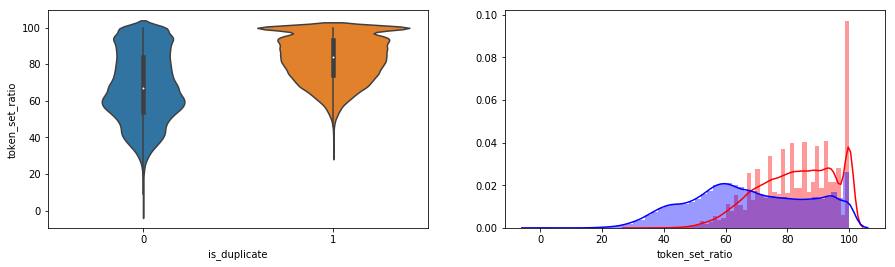

In [35]:
plt.figure(figsize=(15, 4))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data =advance_fet)

plt.subplot(1,2,2)
sns.distplot(advance_fet[advance_fet['is_duplicate'] == 1.0]['token_set_ratio'] , label = "1", color = 'red')
sns.distplot(advance_fet[advance_fet['is_duplicate'] == 0.0]['token_set_ratio'] , label = "0" , color = 'blue' )
plt.show()

#####  Observation: 
##### -> most of the non similar questions have a token_set_ratio bewlo 60 
##### -> most of the  similar questions have a token_set_ratio above  60
##### -> most of the  similar  questions have a token_set_ratio as a 100 many times


###  Dimensionalty Reduction to visualize the class separation in 3 dimensional space

In [36]:
quora_df_sample= advance_fet.sample(frac=0.025)
X = MinMaxScaler().fit_transform(quora_df_sample[['cwc_min', 'cwc_max','cwc_mean', 'csc_min', 'csc_max' , 'csc_mean',
                                                  'ctc_min' , 'ctc_max' , 'ctc_mean','last_word_eq', 'first_word_eq' , 
                                                  'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  
                                                  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = quora_df_sample['is_duplicate'].values

In [37]:
tsne = TSNE(n_components=3,init='random',random_state=101,method='barnes_hut',n_iter=1000,verbose=1,angle=0.5)
tsne3d = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3032 samples in 0.004s...
[t-SNE] Computed neighbors for 3032 samples in 0.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3032
[t-SNE] Computed conditional probabilities for sample 2000 / 3032
[t-SNE] Computed conditional probabilities for sample 3000 / 3032
[t-SNE] Computed conditional probabilities for sample 3032 / 3032
[t-SNE] Mean sigma: 0.163294
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.789017
[t-SNE] KL divergence after 1000 iterations: 0.693987


In [38]:
trace1 = go.Scatter3d(x=tsne3d[:,0],y=tsne3d[:,1],z=tsne3d[:,2],mode='markers',
                      marker=dict(sizemode='diameter',
                                  color = y,
                                  colorscale = 'Portland',
                                  colorbar = dict(title = 'duplicate'),
                                  line=dict(color='rgb(255, 255, 255)'),
                                  opacity=0.75))
data=[trace1]
layout=dict(height=700, width=600, title='3d embedding with engineered features'.upper())
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [39]:
del advance_fet
del basic_fet

## Split the data

In [40]:
y = quora_df['is_duplicate'].values
X=quora_df.drop(['is_duplicate'], axis=1)

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,stratify=y,random_state=42)

## Vectorization

### TF-IDF AvgW2V

In [42]:
merge_ques=list(X_train.question1.values)+list(X_train.question2.values)

In [43]:
tifidf_vectorizer=TfidfVectorizer()
tifidf_vectorizer.fit_transform(merge_ques)
word_2_tfidf=dict(zip(tifidf_vectorizer.get_feature_names(),tifidf_vectorizer.idf_))

In [44]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

def spacy_tfidf_vectorizer(questionary):
    vecs = []
    # https://github.com/noamraph/tqdm
    # tqdm is used to print the progress bar
    for que in tqdm.tqdm_notebook(list(questionary)):
        doc = nlp(que) 
        # 96 is the number of dimensions of vectors 
        rows=len(doc)
        if(rows==0):
            rows=1
            cols=96
        else:
            cols=len(doc[0].vector)
            
        mean_vec = np.zeros([rows,cols])
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            try:
                idf = word_2_tfidf[str(word)]
            except:
                idf = 0
            # compute final vec
            mean_vec += vec * idf
        mean_vec = mean_vec.mean(axis=0)
        vecs.append(mean_vec)
        
    return vecs

In [45]:
basic_tr_vars=basic_feature_generation(X_train).reset_index(drop=True)
advance_tr_vars=extract_features(X_train).reset_index(drop=True)

Preprocessing...
Tokenization....
fuzzy features....


In [46]:
quesion1_tr=spacy_tfidf_vectorizer(X_train.question1.reset_index(drop=True))
quesion_1_df=pd.DataFrame(quesion1_tr)
quesion_1_df.columns=['X_'+str(i) for i in range(96)]

In [47]:
quesion2_tr=spacy_tfidf_vectorizer(X_train.question2.reset_index(drop=True))
quesion_2_df=pd.DataFrame(quesion2_tr)
quesion_2_df.columns=['X_'+str(i) for i in range(96,2*96)]

In [48]:
train_data=pd.concat([basic_tr_vars,advance_tr_vars,quesion_1_df,quesion_2_df], axis=1)

In [49]:
print("Train data set shape:",train_data.shape)

Train data set shape: (90965, 221)


In [50]:
train_data.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+q2,...,X_182,X_183,X_184,X_185,X_186,X_187,X_188,X_189,X_190,X_191
0,1,1,34,48,6,9,3.0,15.0,0.200000,2,...,-42.658581,41.363430,30.772024,43.883427,47.401252,-2.726417,-42.581688,-74.383075,-26.755589,2.576579
1,1,1,24,36,4,6,3.0,10.0,0.300000,2,...,-25.337106,19.736751,-24.106840,-43.948115,-0.675559,10.598111,-0.518173,-28.690342,7.920610,-31.148458
2,1,1,58,60,10,12,0.0,21.0,0.000000,2,...,-127.234508,204.590590,65.382020,-3.482722,-67.734656,-12.956958,69.446811,-65.913355,-33.791150,-20.115037
3,1,1,87,104,17,17,6.0,32.0,0.187500,2,...,-57.203604,11.605730,-39.676138,32.370608,50.607478,54.104120,11.165121,-3.020604,52.834378,70.545829
4,1,1,67,78,10,13,8.0,23.0,0.347826,2,...,-65.607712,112.654627,-14.026819,85.256024,-42.842046,74.439825,28.387675,-222.401056,-77.161236,44.378564


In [51]:
del quesion_1_df
del quesion_2_df

In [52]:
basic_te_vars=basic_feature_generation(X_test).reset_index(drop=True)
advance_te_vars=extract_features(X_test).reset_index(drop=True)

Preprocessing...
Tokenization....
fuzzy features....


In [53]:
quesion1_te=spacy_tfidf_vectorizer(X_test.question1.reset_index(drop=True))
quesion_1_df=pd.DataFrame(quesion1_te)
quesion_1_df.columns=['X_'+str(i) for i in range(96)]

In [54]:
quesion2_te=spacy_tfidf_vectorizer(X_test.question2.reset_index(drop=True))
quesion_2_df=pd.DataFrame(quesion2_te)
quesion_2_df.columns=['X_'+str(i) for i in range(96,2*96)]

In [55]:
test_data=pd.concat([basic_te_vars,advance_te_vars,quesion_1_df,quesion_2_df], axis=1)

In [56]:
print("Test data set shape:",test_data.shape)

Test data set shape: (30322, 221)


In [57]:
test_data.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+q2,...,X_182,X_183,X_184,X_185,X_186,X_187,X_188,X_189,X_190,X_191
0,1,1,24,26,5,5,3.0,10.0,0.300000,2,...,44.074510,36.515241,0.943050,-6.800557,-34.962256,-24.507968,31.778458,-2.664039,-4.757643,-16.771604
1,1,1,25,19,5,4,3.0,9.0,0.333333,2,...,5.638598,-5.201934,-9.449183,2.188452,-4.227353,-2.191552,5.538854,-2.958465,-0.809028,6.778326
2,2,1,21,19,4,4,2.0,8.0,0.250000,3,...,-8.047821,-9.393710,7.157021,29.664151,3.686387,9.359437,-2.391648,-18.396649,11.877298,20.077112
3,1,1,22,27,5,7,1.0,12.0,0.083333,2,...,-13.793809,46.768842,21.043684,76.467500,-2.064960,6.518198,20.797883,-60.494637,-55.525882,-7.730681
4,1,1,35,47,6,9,3.0,15.0,0.200000,2,...,-51.469934,60.899350,-6.111548,66.125746,35.958518,-21.428615,59.508844,-42.325064,-6.385056,37.429352


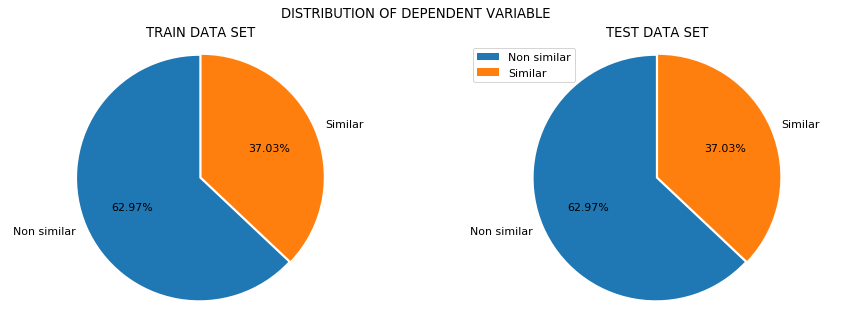

In [58]:
# Pie chart
#code ref:https://medium.com/@kvnamipara

plt.rcParams.update({'font.size': 11})
labels = ['Non similar', 'Similar']
sizes = [list(Counter(y_train).values()),list(Counter(y_test).values())]
titles=['Train data set','Test data set']
fig, ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Distribution of Dependent Variable".upper())
for i in range(2):
    ax[i].pie(sizes[i], labels=labels, explode=[0,0.02],autopct='%1.2f%%',startangle=90)
    ax[i].axis('equal')  
    ax[i].set_title('{}'.format(titles[i]).upper())
plt.legend()
plt.show()

In [59]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(y, y_hat):
    
    conf_matrix= confusion_matrix(y, y_hat)
    
    recall_matrix =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)
    
    prec_matrix =(conf_matrix/conf_matrix.sum(axis=0))

    plt.figure(figsize=(20,5))
    plt.rcParams.update({'font.size': 12.2})
    
    labels = ['NS','S']
    # representing conf_matrix in heatmap format
    
    #Code ref:https://seaborn.pydata.org/tutorial/color_palettes.html
    flatui = ["#3498db", "#34495e"]
    cmap=sns.color_palette(flatui)
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels,cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix".upper(),pad=15)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(prec_matrix, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels,cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix".upper(),pad=15)
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(recall_matrix, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels,cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix".upper(),pad=15)
    
    plt.legend(['Non Simialr','Similar'])
    plt.show()

## Model Training

### Random_Model


Log loss on Test Data using Random Model 0.8898240819886288


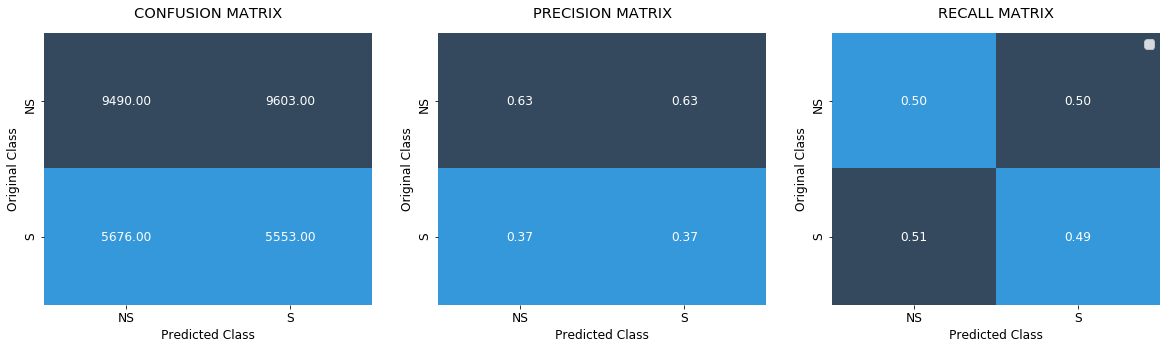

In [60]:
predicted_y=np.zeros((len(y_test),2))

for each_y in tqdm.tqdm_notebook(range(len(y_test))):
    random_pred=np.random.rand(1,2)
    predicted_y[each_y] = ((random_pred/sum(sum(random_pred)))[0])

print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test,predicted_y)
    

In [61]:
def_model=SGDClassifier()

In [62]:
alpha_vals=[10**i  for i in range(-4,5)]
# Avoid the bais towards the class which has more number of observations
def_model.class_weight='balanced'
def_model.n_jobs=-1

In [63]:
def reduce_log_loss(clf,hyper_vals,X_tr,y_tr,X_te,y_te,loss_term,penalty_term,n_split):

    train_log_error_array=[]
    test_log_error_array=[]
    clf.loss=loss_term
    clf.penalty=penalty_term
    
    for each_val in tqdm.tqdm_notebook(sorted(hyper_vals)):
        
        clf.alpha=each_val
        clf=clf.fit(X_tr,y_tr)
        
        #used CalibratedClassifierCV to get the probabilty scores 
        prob_clf=CalibratedClassifierCV(clf,method='sigmoid',cv=n_split)
        prob_clf.fit(X_tr,y_tr)
        
        predict_y_tr = prob_clf.predict_proba(X_tr)
        predict_y_te = prob_clf.predict_proba(X_te)
        
        train_log_error_array.append(log_loss(y_tr, predict_y_tr, labels=clf.classes_, eps=1e-15))
        test_log_error_array.append(log_loss(y_te, predict_y_te, labels=clf.classes_, eps=1e-15))
        
        print('For values of alpha = ', each_val, "The log loss is:",
              log_loss(y_test, predict_y_te, labels=clf.classes_, eps=1e-15))
    
    font = {'family' : 'normal','weight' : 'bold','size': 10}
    plt.figure(figsize=(9,6))
    
    plt.plot(np.log10(hyper_vals), train_log_error_array,c='g',label="Train logloss")
    plt.plot(np.log10(hyper_vals), test_log_error_array,c='tomato',label="Test logloss")
    
    for i in range(len(hyper_vals)):
        plt.text(np.log10(hyper_vals)[i],test_log_error_array[i],str(np.round(test_log_error_array[i],5)),fontdict=font)
    plt.title("Cross Validation Error for each alpha".upper(),pad=20)
    
    plt.xlabel("Alpha i's to the power of 10")
    plt.ylabel("Error measure")
    plt.legend()
    plt.show()
    

    clf.alpha=hyper_vals[np.argmin(test_log_error_array)]
    clf.fit(X_tr, y_tr)
    prob_clf = CalibratedClassifierCV(clf, method="sigmoid")
    prob_clf.fit(X_tr, y_tr)
    
    predict_y = prob_clf.predict_proba(X_tr)
    print('For values of best alpha = ', clf.alpha, "The train log loss is:",
          log_loss(y_tr, predict_y, labels=prob_clf.classes_, eps=1e-15))
    
    predict_y = prob_clf.predict_proba(X_te)
    print('For values of best alpha = ', clf.alpha, "The test log loss is:",
          log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    
    predicted_y =np.argmax(predict_y,axis=1)
    
    print("Total number of data points :", len(predicted_y))
    
    plot_confusion_matrix(y_test, predicted_y)


In [69]:
def train_xgboost(train_df,no_estimator):
    cv_results = xgb.cv(dtrain=train_df, params=hyper_params, nfold=4,
                        num_boost_round=no_estimator,early_stopping_rounds=10, as_pandas=True, seed=123,verbose_eval=200)

    font = {'family' : 'normal','weight' : 'bold','size'   : 10}
    plt.figure(figsize=(12,8))

    test_log_error=cv_results['test-logloss-mean']
    train_log_error=cv_results['train-logloss-mean']
    index=list(cv_results.index.values)

    plt.plot(index,test_log_error)
    plt.plot(index,train_log_error)

    plt.scatter(index[::100],test_log_error[::100])
    plt.scatter(index[::100],train_log_error[::100])

    for i in range(0,no_estimator,100):
        plt.text(i,test_log_error[i],str(np.round(test_log_error[i],3)))
        plt.text(i,train_log_error[i],str(np.round(train_log_error[i],3)))

    plt.title("Error plot for Train and Test data".upper(),pad=20)
    plt.legend(['Test Log Loss','Train Log Loss'])
    plt.xlabel("Number of Estimators")
    plt.ylabel("Error in Log loss")
    plt.show()

##### Logistic Regression

For values of alpha =  0.0001 The log loss is: 0.5789493077927336
For values of alpha =  0.001 The log loss is: 0.5764184377385114
For values of alpha =  0.01 The log loss is: 0.569600364533187
For values of alpha =  0.1 The log loss is: 0.5772708999697878
For values of alpha =  1 The log loss is: 0.5569197532059461
For values of alpha =  10 The log loss is: 0.5635105516166578
For values of alpha =  100 The log loss is: 0.5772448785666826
For values of alpha =  1000 The log loss is: 0.5928081235784759
For values of alpha =  10000 The log loss is: 0.6146642528275224



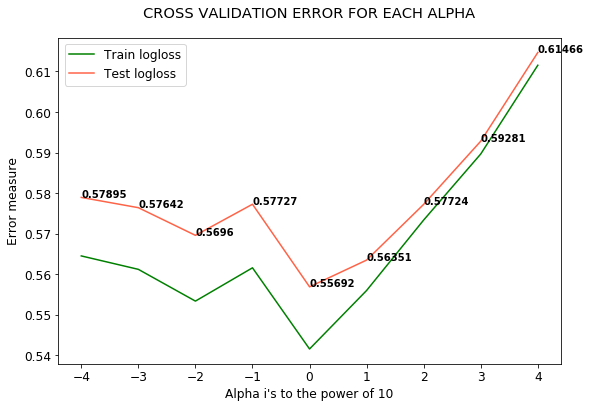

For values of best alpha =  1 The train log loss is: 0.5459377803051935
For values of best alpha =  1 The test log loss is: 0.5604847179849198
Total number of data points : 30322


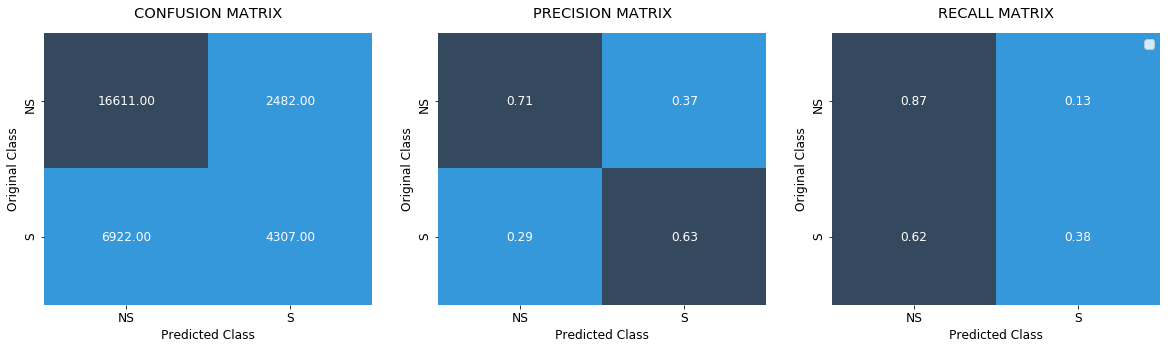

In [64]:
reduce_log_loss(def_model,alpha_vals,train_data,y_train,test_data,y_test,'log','l2',7)

#####  SVM with Linear Model

For values of alpha =  0.0001 The log loss is: 0.5536398152402491
For values of alpha =  0.001 The log loss is: 0.5560618680484122
For values of alpha =  0.01 The log loss is: 0.569328107946569
For values of alpha =  0.1 The log loss is: 0.6137047032569626
For values of alpha =  1 The log loss is: 0.6353989545269958
For values of alpha =  10 The log loss is: 0.6563251636445342
For values of alpha =  100 The log loss is: 0.6502002909877735
For values of alpha =  1000 The log loss is: 0.6591285183694718
For values of alpha =  10000 The log loss is: 0.659128518369472



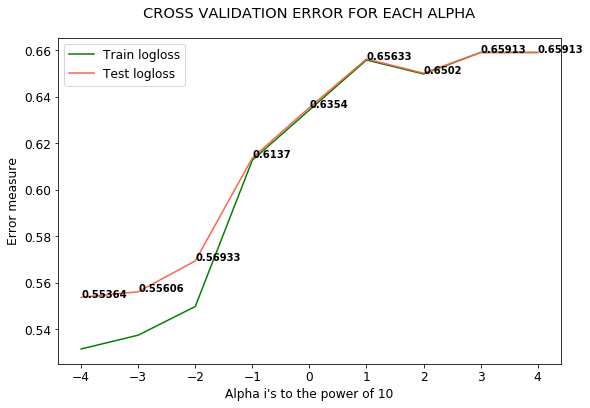

For values of best alpha =  0.0001 The train log loss is: 0.5432140696576151
For values of best alpha =  0.0001 The test log loss is: 0.5656956556244139
Total number of data points : 30322


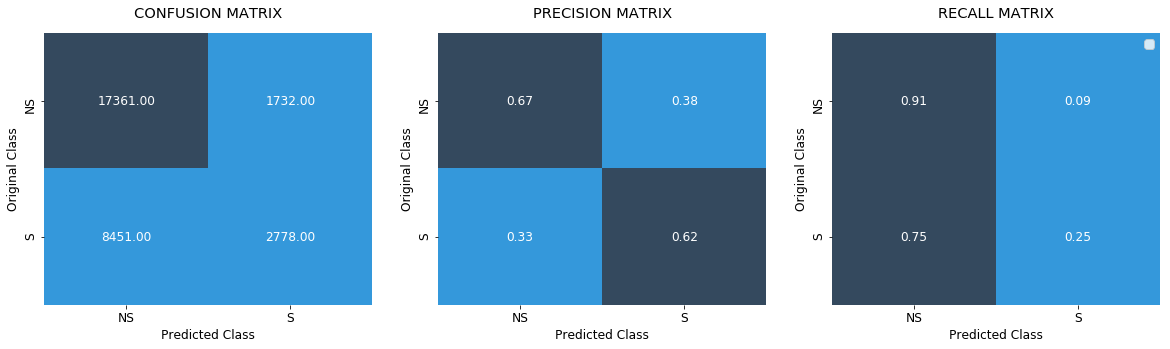

In [66]:
reduce_log_loss(def_model,alpha_vals,train_data,y_train,test_data,y_test,'hinge','l1',7)

######  XG Boost Classifier

In [67]:
hyper_params = dict()
hyper_params['objective'] = 'binary:logistic'
hyper_params['eval_metric'] = 'logloss'
hyper_params['eta'] = 0.02
hyper_params['max_depth'] = 4
no_estimators=1500


d_train_avg = xgb.DMatrix(train_data, label=y_train)
d_test_avg = xgb.DMatrix(test_data, label=y_test)

[0]	train-logloss:0.685575+2.01556e-05	test-logloss:0.685592+3.62586e-05
[200]	train-logloss:0.409092+0.000752329	test-logloss:0.412865+0.00186627
[400]	train-logloss:0.38278+0.000638867	test-logloss:0.392899+0.00189159
[600]	train-logloss:0.367578+0.000836433	test-logloss:0.384369+0.00180385
[800]	train-logloss:0.356343+0.000934578	test-logloss:0.379623+0.00184142
[1000]	train-logloss:0.347178+0.000950214	test-logloss:0.376662+0.00194334
[1200]	train-logloss:0.339052+0.000950808	test-logloss:0.374663+0.00196727
[1400]	train-logloss:0.331598+0.00102101	test-logloss:0.373151+0.00200724
[1499]	train-logloss:0.328116+0.000983776	test-logloss:0.37251+0.00210959


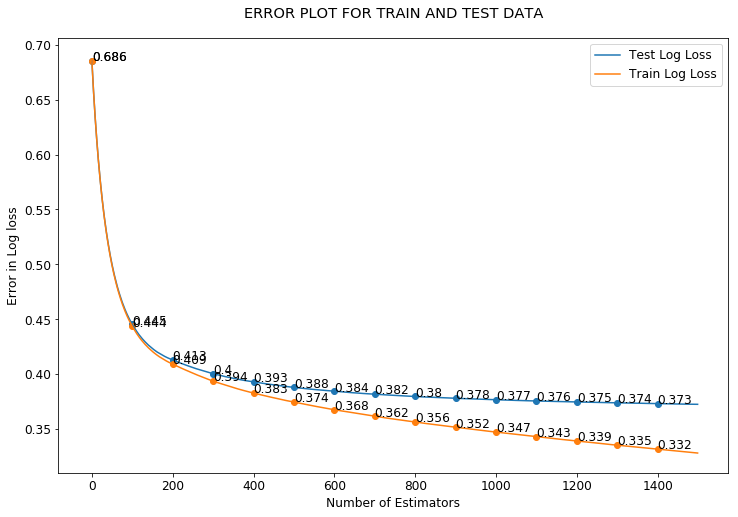

In [70]:
train_xgboost(d_train_avg,no_estimators)

In [116]:
xgb_model=xgb.XGBClassifier(max_depth=4,learning_rate=0.02,n_estimators=300,n_jobs=-1)

In [117]:
def print_loss_confusion_matrix(model,X_tr,X_te,y_tr,y_te):
    
    model.fit(X_tr, y_tr)
    predict_y = model.predict_proba(X_tr)
    best_param=model.get_params()['n_estimators']
    
    print('For', best_param, " number of  estimators The train log loss is:",
          log_loss(y_tr, predict_y, labels=model.classes_, eps=1e-15))
    
    predict_y = model.predict_proba(X_te)
    print('For',best_param, " number of  estimators The Test  log loss is:",
          log_loss(y_te, predict_y, labels=model.classes_, eps=1e-15))
    
    predicted_y =np.argmax(predict_y,axis=1)
    
    print("Total number of data points :", len(predicted_y))
    
    plot_confusion_matrix(y_te, predicted_y)

For 300  number of  estimators The train log loss is: 0.3955669963135318
For 300  number of  estimators The Test  log loss is: 0.43563792579497584
Total number of data points : 30322


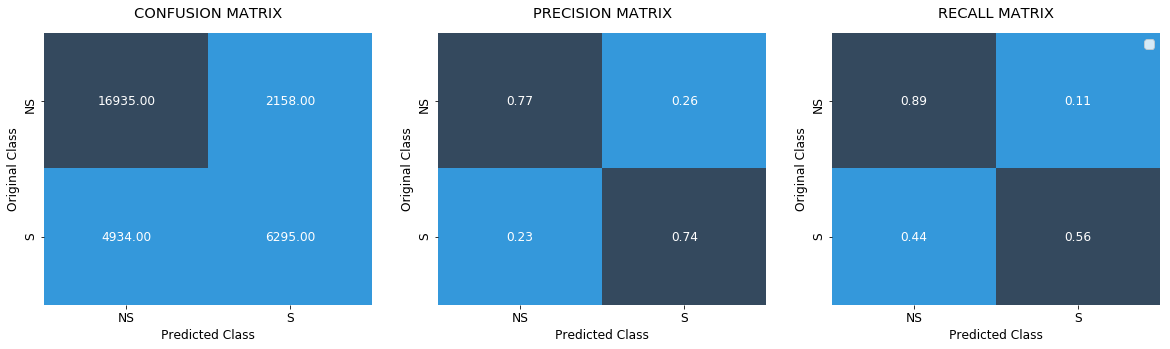

In [118]:
print_loss_confusion_matrix(xgb_model,train_data,test_data,y_train,y_test)

##  TF-IDF

In [100]:
tf_idf_vectorizer=TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vectorizer.fit(merge_ques)

X_tr_que1=tf_idf_vectorizer.transform(X_train.question1.values)
X_tr_que2=tf_idf_vectorizer.transform(X_train.question2.values)

X_te_que1=tf_idf_vectorizer.transform(X_test.question1.values)
X_te_que2=tf_idf_vectorizer.transform(X_test.question2.values)


In [101]:
tf_train_data=hstack((basic_tr_vars,advance_tr_vars,X_tr_que1,X_tr_que2))

In [102]:
tf_test_data=hstack((basic_te_vars,advance_te_vars,X_te_que1,X_te_que2))

###### Logistic Regression

For values of alpha =  0.0001 The log loss is: 0.5308592814938068
For values of alpha =  0.001 The log loss is: 0.5297933522353618
For values of alpha =  0.01 The log loss is: 0.5329670461161012
For values of alpha =  0.1 The log loss is: 0.5405829558356555
For values of alpha =  1 The log loss is: 0.5610911536015519
For values of alpha =  10 The log loss is: 0.5851579111039358
For values of alpha =  100 The log loss is: 0.5959025879874169
For values of alpha =  1000 The log loss is: 0.5944665730360171
For values of alpha =  10000 The log loss is: 0.5833218799638276



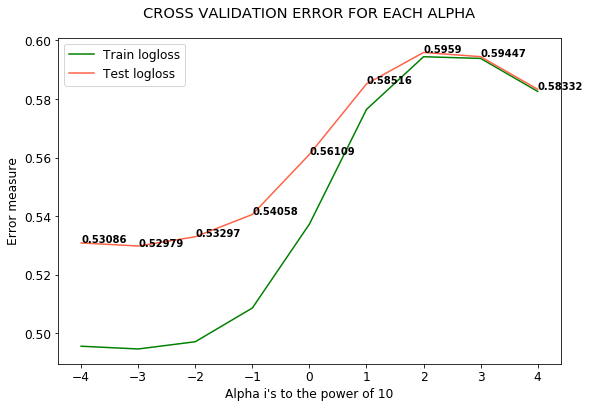

For values of best alpha =  0.001 The train log loss is: 0.5028550247133672
For values of best alpha =  0.001 The test log loss is: 0.5368012827269227
Total number of data points : 30322


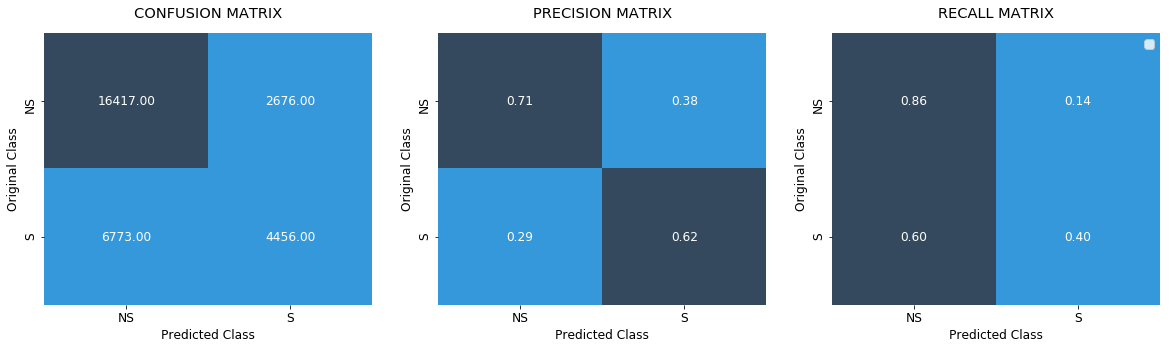

In [103]:
reduce_log_loss(def_model,alpha_vals,tf_train_data,y_train,tf_test_data,y_test,'log','l2',7)

###### SVM Liner Model

For values of alpha =  0.0001 The log loss is: 0.5464620067987404
For values of alpha =  0.001 The log loss is: 0.5571565179986848
For values of alpha =  0.01 The log loss is: 0.5748096656067511
For values of alpha =  0.1 The log loss is: 0.5585146273036163
For values of alpha =  1 The log loss is: 0.5961683277524672
For values of alpha =  10 The log loss is: 0.613266024088602
For values of alpha =  100 The log loss is: 0.659128518369472
For values of alpha =  1000 The log loss is: 0.659128518369472
For values of alpha =  10000 The log loss is: 0.659128518369472



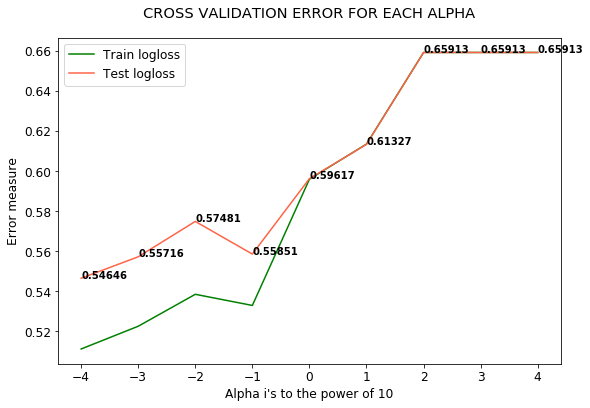

For values of best alpha =  0.0001 The train log loss is: 0.5104700314772985
For values of best alpha =  0.0001 The test log loss is: 0.544985873163815
Total number of data points : 30322


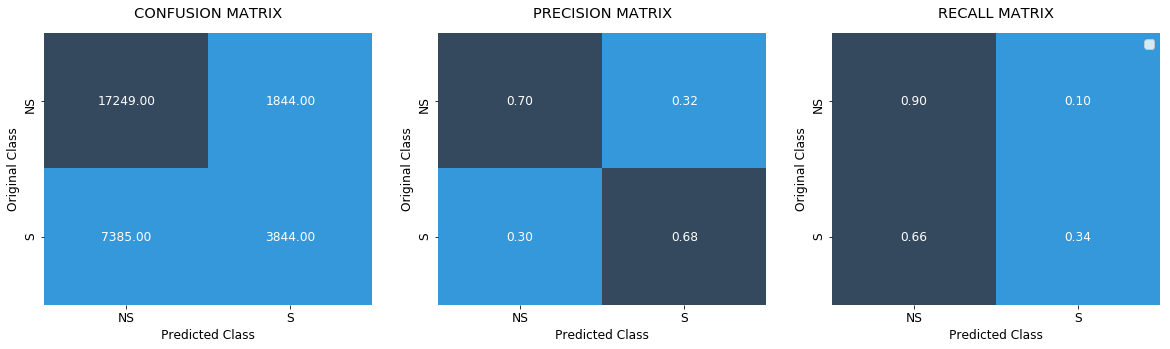

In [104]:
reduce_log_loss(def_model,alpha_vals,tf_train_data,y_train,tf_test_data,y_test,'hinge','l1',7)

###### XG Boost Classifer

In [106]:
d_train_tfidf = xgb.DMatrix(tf_train_data, label=y_train)
d_test_tfidf = xgb.DMatrix(tf_test_data, label=y_test)

[0]	train-logloss:0.685571+1.9331e-05	test-logloss:0.685588+3.33579e-05
[200]	train-logloss:0.40902+0.00093139	test-logloss:0.412879+0.00173087
[400]	train-logloss:0.385969+0.00111414	test-logloss:0.393464+0.0017985
[600]	train-logloss:0.374569+0.00116406	test-logloss:0.38554+0.00189157
[800]	train-logloss:0.366722+0.00106167	test-logloss:0.380725+0.00197425
[1000]	train-logloss:0.360409+0.00103031	test-logloss:0.377311+0.00201182
[1200]	train-logloss:0.35513+0.00105451	test-logloss:0.374707+0.00205262
[1400]	train-logloss:0.350482+0.00111546	test-logloss:0.372598+0.00201921
[1499]	train-logloss:0.348378+0.00108392	test-logloss:0.371679+0.00207409


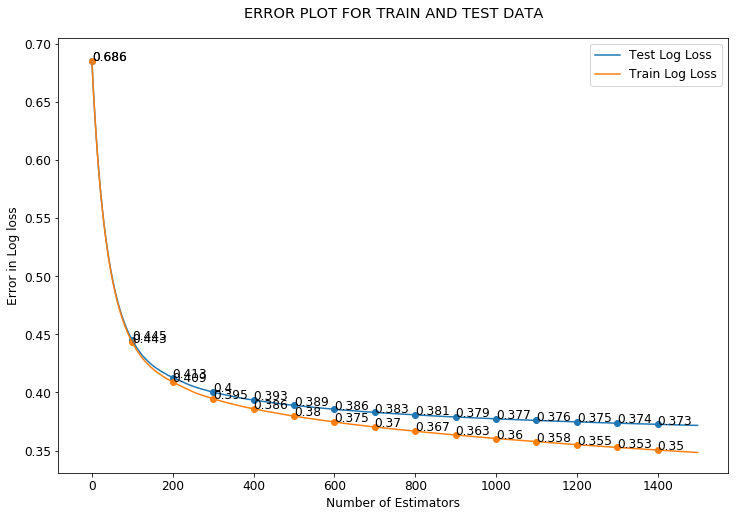

In [107]:
train_xgboost(d_train_tfidf,no_estimators)

In [114]:
xgb_model=xgb.XGBClassifier(max_depth=4,learning_rate=0.02,n_estimators=300,n_jobs=-1)

For 300  number of  estimators The train log loss is: 0.395978417222747
For 300  number of  estimators The Test  log loss is: 0.43321962107498485
Total number of data points : 30322


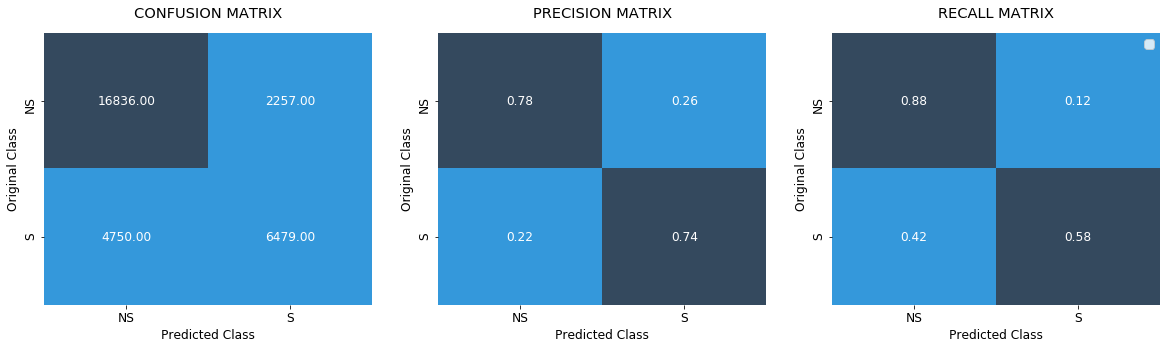

In [115]:

print_loss_confusion_matrix(xgb_model,tf_train_data,tf_test_data,y_train,y_test)

In [124]:
from prettytable import PrettyTable
summary_table = PrettyTable()
summary_table.hrules=True

summary_table.field_names=['Model',"Vectorizer",'Best Param',"Train Log Loss", "Test Log Loss"]
summary_table.add_row(['Logistic Regression',"TF-IDF AVGW2V",  'alpha:1',0.545,.560])
summary_table.add_row(['Linear SVM ',"TF-IDF AVGW2V",'alpha:0.0001',.543,.565])
summary_table.add_row(['XG Boost',"TF-IDF AVGW2V", 'n_estimaters: 300',.395,.435])
summary_table.add_row(['Logistic Regression',"TF-IDF", 'alpha:0.001',0.502,.536])
summary_table.add_row(['Linear SVM ',"TF-IDF", 'alpha:0.0001',0.510,.544])
summary_table.add_row(['XG Boost',"TF-IDF", 'n_estimaters: 300', .395,.433])

summary_table.sortby='Test Log Loss'
print(summary_table)


+---------------------+---------------+-------------------+----------------+---------------+
|        Model        |   Vectorizer  |     Best Param    | Train Log Loss | Test Log Loss |
+---------------------+---------------+-------------------+----------------+---------------+
|       XG Boost      |     TF-IDF    | n_estimaters: 300 |     0.395      |     0.433     |
+---------------------+---------------+-------------------+----------------+---------------+
|       XG Boost      | TF-IDF AVGW2V | n_estimaters: 300 |     0.395      |     0.435     |
+---------------------+---------------+-------------------+----------------+---------------+
| Logistic Regression |     TF-IDF    |    alpha:0.001    |     0.502      |     0.536     |
+---------------------+---------------+-------------------+----------------+---------------+
|     Linear SVM      |     TF-IDF    |    alpha:0.0001   |      0.51      |     0.544     |
+---------------------+---------------+-------------------+-----------